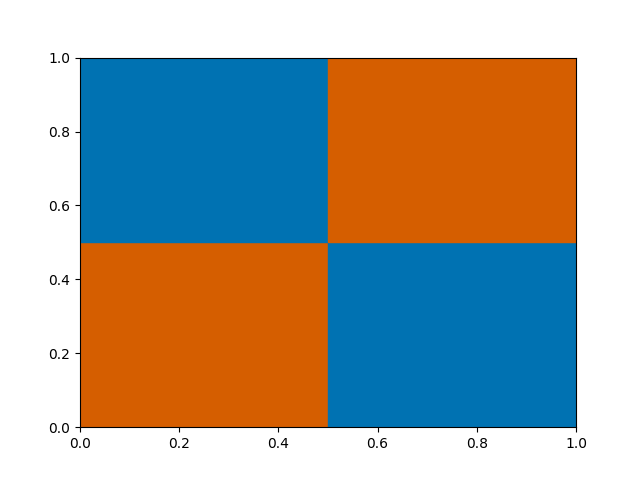

In [1]:
%matplotlib widget
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.patches as patches

category_a_color = "#009E73" # (Green)
category_b_color = "#CC79A7" # (Magenta)

def reset_plot():
    plt.close()
    class_a_color = "#D55E00" # orange
    class_b_color = "#0072B2" # blue
    class_colors = iter([class_a_color, class_b_color, class_b_color, class_a_color])
    figure, axes = plt.subplots()
    
    #bottom left, top left, bottom right, top right
    origins = [(0,0), (0, 0.5), (0.5, 0), (0.5, 0.5)]
    for origin in origins:
        class_color = next(class_colors)
        rectangle = patches.Rectangle(origin, 0.5, 0.5, linewidth=1, edgecolor=class_color, facecolor=class_color)
        axes.add_patch(rectangle)


    input_area = patches.Rectangle((0, 0), 1, 1, linewidth=1, edgecolor="g", facecolor='none')
    return axes, figure

reset_plot()
plt.show()

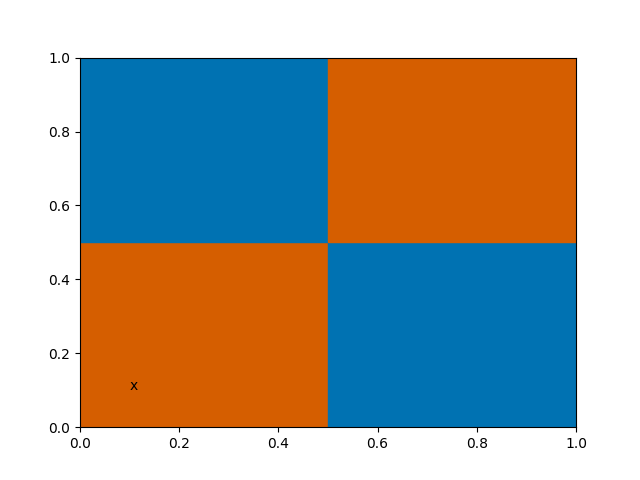

In [2]:
# first point - category A
axes, fig = reset_plot()
# This is `a` in Carpenter et al. 1992 - Fig. 1
first_point = np.array((0.1, 0.1))
axes.text(*first_point, "x")
plt.show()

In [3]:
# This is `A` (the result of F0) in Carpenter et al. 1992 - Fig. 1
# The value A is the concatenation of the first point (a) with its complement
complement_encoded_first_point = np.concatenate((first_point, 1-first_point))

# rho_a bar
baseline_vigilance = 0.7

# map field vigilance, rho_ab
map_field_vigilance = .95

# alpha
choice_parameter = 0.001

# beta
learning_rate = 1.0

#beta_ab
map_field_learning_rate = 1.0

number_of_complement_encoded_dimensions = complement_encoded_first_point.shape[0] # 4 dimensions
# the weight mapping between F1 and F2, the number of F2 nodes may grow, but the width (columns) is limited to the complement encoded input size
weight_a = np.ones((1,number_of_complement_encoded_dimensions))

# the weight mapping between F2 and the map field F_ab - the width is limited to the complement encoded size of the categories
# we only have 2 categories (A and B) that can be mapped to a one-dimensional vector - (1) for category A, (0) for category B
# with complement encoding, it is a two-dimensional vector
# category A - (1,0) - by C = (c, 1-c)
category_a_vector = np.array([[1,0]])

# category B - (0,1) - by C = (c, 1-c)
category_b_vector = np.array([[0,1]])

weight_ab = np.ones((1,2))

j = 0

# calculate category choice eq. 2
# Fuzzy AND is the point-wise minimum (Carpenter et al., 1992, Zadeh, 1965)
# |*| norm is the L-1 norm - vector sum (eq. 4)
category_choice_numerator = np.sum(np.minimum(complement_encoded_first_point, weight_a[j:]))
category_choice_denominator = choice_parameter + np.sum(weight_a[j:])
category_choice = category_choice_numerator / category_choice_denominator

# only one category currently, so Tj argmax = 0
# for the match function (see the text just above eq 7) the numerator is the same as the category choice, and the denominator is |A|
match_function_denominator = np.sum(complement_encoded_first_point)
match_function = category_choice_numerator / match_function_denominator

# node 0 is uncommited so it triggers resonance
fuzzy_art_a_resonance = match_function >= baseline_vigilance

J = j

# next, check the map field activation (eq. 34)
# instead of a full Fuzzy ART B implementation to get the y_b values, the category vector is used instead
x_ab = np.minimum(category_a_vector, weight_ab[J:])

# squint at eq 35 - the version given |x_ab| < rho_ab|y_b|, is the _mismatch reset_ equation (compare with eq 9)
# rebalancing the inequality, you get |x_ab|/|y_b| >= rho_ab (compare with eq. 7)
match_tracking = np.sum(x_ab)/np.sum(category_a_vector)
map_field_resonance = match_tracking >= map_field_vigilance

# since this is the fist category across the board, map_field_resonance is True
# and we can commit node 0 (weight_a[0]) to category A and learn the new weights for
# the connection between F1 and F2 (weight_a) and between F2 and the "map field" (weight_ab)
# (see eq 11)
weight_a[J, None] = (learning_rate * np.minimum(complement_encoded_first_point, weight_a[J, None])) + ((1-learning_rate) * weight_a[J, None])
# see Carpenter et al. 1995 eq 1; the map field learning rules in Carpenter et al. 1992, are brief and fairly opaque
weight_ab[J, None] = ((1 - map_field_learning_rate) * weight_ab[J, None]) + (map_field_learning_rate * np.minimum(category_a_vector, weight_ab[J:]))

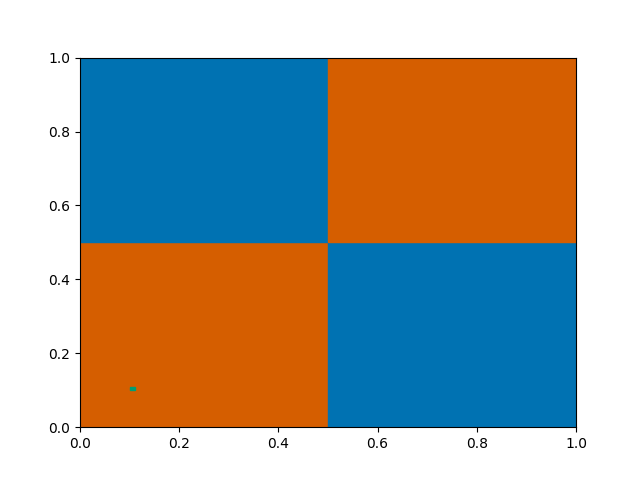

In [4]:
def visualize_category_zero():
    # finally, the weight_a can be visualized, per Carpenter et al. 1992, see Fig. 3
    axes, fig = reset_plot()
    # extract the first point from the first half (index 0 and 1) of the category 0 weight 
    # called u_j in Fig 3
    bottom_left_point = (weight_a[0,0], weight_a[0,1])

    # extract the second point from the second half (index 2 and 3) of the category 0 weight 
    # called v_j in Fig 3
    top_right_point = (weight_a[0,2], weight_a[0,3])

    # convert points to height and width for matplotlib, set a minimum 0.01x0.01 because the actual rectangle is a point initially
    height = max((1-top_right_point[1]) - bottom_left_point[1], 0.01)
    width = max((1-top_right_point[0]) - bottom_left_point[0], 0.01)
    category_rectangle = patches.Rectangle(bottom_left_point, width, height, linewidth=1, edgecolor=category_a_color, facecolor=category_a_color)
    axes.add_patch(category_rectangle)
    plt.show()
    return axes, fig
axes, fig = visualize_category_zero()

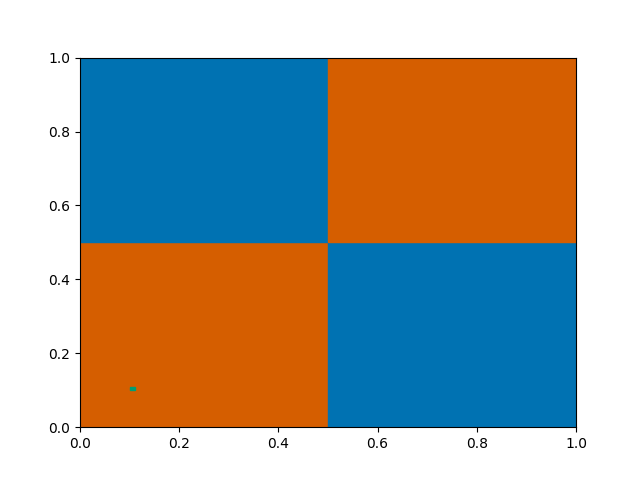

Text(0.9, 0.1, 'x')

In [5]:
# second point - category B
second_point = np.array((0.9, 0.1))
ax, fig = visualize_category_zero()
ax.text(*second_point, "x")


In [6]:
complement_encoded_second_point = np.concatenate((second_point, 1-second_point))

j = 0 # start with category 0

category_choice_numerator = np.sum(np.minimum(complement_encoded_second_point, weight_a[j:]))
category_choice_denominator = choice_parameter + np.sum(weight_a[j:])

# category choice is now significantly less than 1.0 (0.599), because category 0 is commited 
# and the second point is outside of the category
category_choice = category_choice_numerator / category_choice_denominator

# still only one category currently, so Tj argmax = 0
match_function_denominator = np.sum(complement_encoded_second_point)
match_function = category_choice_numerator / match_function_denominator

# node 0 is commited and a poor match with the second point for the baseline vigilance
# this triggers a reset
fuzzy_art_a_resonance = match_function >= baseline_vigilance

# now, we have a reset, and we only have one category in F2, represented by the one weight value in weight_a
# conceptually we need to _add a new node_ to F2
# Therefore, we need new weights connecting F1 -> F2 (weight_a) and F2 -> Map Field (weight_ab)
# *Practically* what does this mean? 
# We need to add a _row_ of ones to each weight array, of the same number of _columns_
# For weight_a (connecting F1->F2) this is the number of complement encoded input dimensions (4), like we initialized above
# For weight_ab (connecting F2 -> Map Field) this is the number of complement encoded category dimensions (2), like we initialized above
weight_a = np.vstack((weight_a, np.ones((1,number_of_complement_encoded_dimensions))))
weight_ab = np.vstack((weight_ab, np.ones((1,2))))

# since we've already reset on category (j) 0, we will skip it, 
# and instead perform the category choice and resonance check on the _new_ node
j = 1

category_choice_numerator = np.sum(np.minimum(complement_encoded_second_point, weight_a[j:]))
category_choice_denominator = choice_parameter + np.sum(weight_a[j:])

# category choice is now 1.0 because category 1 is new and uncommited 
category_choice = category_choice_numerator / category_choice_denominator

# Tj argmax = 1, since the new category by definition must match
match_function_denominator = np.sum(complement_encoded_second_point)
match_function = category_choice_numerator / match_function_denominator

# node 1 is uncommited and theorefore a good match and triggers resonance
fuzzy_art_a_resonance = match_function >= baseline_vigilance

J = j
# next, check the map field activation (eq. 34)
# instead of a full Fuzzy ART B implementation to get the y_b values, the category vector is used instead
x_ab = np.minimum(category_b_vector, weight_ab[J:])

# squint at eq 35 - the version given |x_ab| < rho_ab|y_b|, is the _mismatch reset_ equation (compare with eq 9)
# rebalancing the inequality, you get |x_ab|/|y_b| >= rho_ab (compare with eq. 7)
match_tracking = np.sum(x_ab)/np.sum(category_b_vector)
map_field_resonance = match_tracking >= map_field_vigilance

# since this is the fist category across the board, map_field_resonance is True
# and we can commit node 0 (weight_a[0]) to category A and learn the new weights for
# the connection between F1 and F2 (weight_a) and between F2 and the "map field" (weight_ab)
# (see eq 11)
weight_a[J, None] = (learning_rate * np.minimum(complement_encoded_second_point, weight_a[J, None])) + ((1-learning_rate) * weight_a[J, None])
# see Carpenter et al. 1995 eq 1; the map field learning rules in Carpenter et al. 1992, are brief and fairly opaque
weight_ab[J, None] = ((1 - map_field_learning_rate) * weight_ab[J, None]) + (map_field_learning_rate * np.minimum(category_b_vector, weight_ab[J:]))

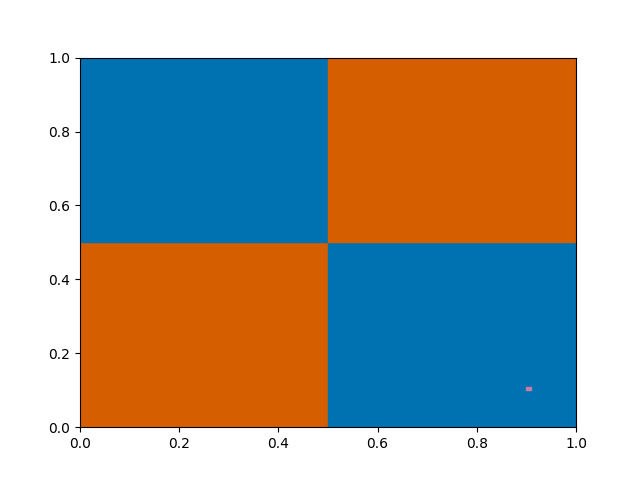

In [7]:
def visualize_category_one():
    # finally, the weight_a can be visualized for category one, per Carpenter et al. 1992, see Fig. 3
    axes, fig = reset_plot()
    # extract the first point from the first half (index 0 and 1) of the category 1 weight 
    # called u_j in Fig 3
    bottom_left_point = (weight_a[1,0], weight_a[1,1])

    # extract the second point from the second half (index 2 and 3) of the category 1 weight 
    # called v_j in Fig 3
    top_right_point = (weight_a[1,2], weight_a[1,3])

    # convert points to height and width for matplotlib, set a minimum 0.01x0.01 because the actual rectangle is a point initially
    height = max((1-top_right_point[1]) - bottom_left_point[1], 0.01)
    width = max((1-top_right_point[0]) - bottom_left_point[0], 0.01)
    category_rectangle = patches.Rectangle(bottom_left_point, width, height, linewidth=1, edgecolor=category_b_color, facecolor=category_b_color)
    axes.add_patch(category_rectangle)
    plt.show()
    return axes, fig
axes, fig = visualize_category_one()

(<Axes: >, <Figure size 640x480 with 1 Axes>)

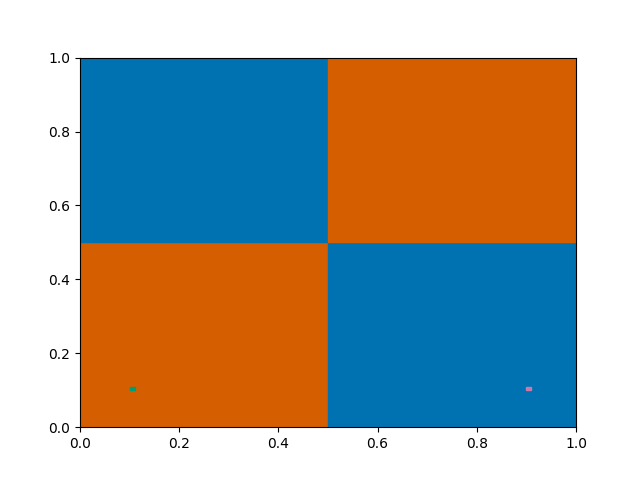

In [8]:
# now that we've seen two categories let's take a moment to refactor the category visualization
from matplotlib.axes import Axes
from matplotlib.figure import Figure

def visualize_category(category_index: int, 
                        category_color: str,
                        existing_axes: Axes = None,
                        existing_fig: Figure = None):
    """
    Visualize a category (category_index) from weight_a
    with the specified category_color, an "x" at the point.
    If the "x" should move slightly left, set offset_left.
    If adding to an existing plot, pass in the existing_axes
    """    
    if existing_axes:
        axes = existing_axes
        fig = existing_fig
    else:
        axes, fig = reset_plot()
    

    # extract the first point from the first half (index 0 and 1) of the category weight 
    # called u_j in Fig 3
    bottom_left_point = (weight_a[category_index,0], weight_a[category_index,1])

    # extract the second point from the second half (index 2 and 3) of the category weight 
    # called v_j in Fig 3
    top_right_point = (weight_a[category_index,2], weight_a[category_index,3])

    # convert points to height and width for matplotlib, set a minimum 0.01x0.01 because the actual rectangle is a point initially
    height = max((1-top_right_point[1]) - bottom_left_point[1], 0.01)
    width = max((1-top_right_point[0]) - bottom_left_point[0], 0.01)
    category_rectangle = patches.Rectangle(bottom_left_point, width, height, linewidth=1, edgecolor=category_color, facecolor=category_color)
    axes.add_patch(category_rectangle)
    # plt.show()
    return axes, fig

def visualize_categories():
    category_a = weight_ab[:, 0] > weight_ab[:, 1]
    a = None
    f = None
    for j in range(weight_a.shape[0]):
        is_category_a = category_a[j]
        color_to_use = category_b_color
        if is_category_a:
            color_to_use = category_a_color
        a, f = visualize_category(j, color_to_use, a, f)
    return a, f

visualize_categories()

Text(0.9, 0.9, 'x')

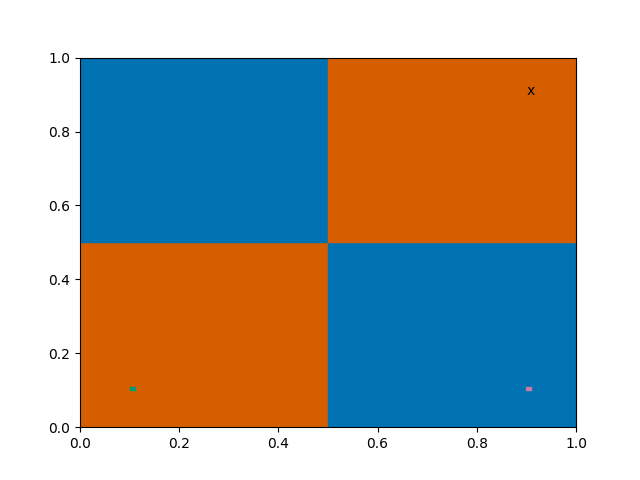

In [9]:

# third point - category A
third_point = np.array((0.9, 0.9))
a, f = visualize_categories()
a.text(*third_point, "x")


In [22]:
# As you might have suspected, for this third point, neither of the existing two
# categories are going to match, so rather than repeat the same code over and over again
# for the number of categories, let's write a function to help us

complement_encoded_third_point = np.concatenate((third_point, 1-third_point))

def resonant_a_search(complement_encoded_point, vigilance, already_seen_nodes = None):
    global weight_a
    global weight_ab
    # first calculate all the category choice valules (see II.Category Choice in Carpenter et al. 1992)
    # create a T array to hold each of the T_j values, equal to the number of F2 nodes
    T = np.zeros((weight_a.shape[0]))
    for j in range(weight_a.shape[0]):
        category_choice_numerator = np.sum(np.minimum(complement_encoded_point, weight_a[j:]))
        category_choice_denominator = choice_parameter + np.sum(weight_a[j:])
        category_choice = category_choice_numerator / category_choice_denominator
        # this now fully reflects eq 2
        T[j] = category_choice

    fuzzy_art_a_resonance = False
    seen_nodes = []
    if already_seen_nodes:
        # keep track of nodes that have been disconfirmed
        # by the map field resonance/reset check
        seen_nodes.extend(already_seen_nodes)
        for node in already_seen_nodes:
            T[node] = 0
    
    while not fuzzy_art_a_resonance:
        # now to calculate J - eq 5
        J = np.argmax(T)

        # calculate the match function for the selected J (eq 7)
        match_function_numerator = np.sum(np.minimum(complement_encoded_point, weight_a[J:]))
        match_function_denominator = np.sum(weight_a[J:])
        match_function = match_function_numerator / match_function_denominator
        
        fuzzy_art_a_resonance = match_function >= vigilance
        if fuzzy_art_a_resonance:
            # return the winning category index
            return J
        
        # if not resonance, we reset, and per the text "Then the value of the choice function
        # T_J is set to 0 for the duration of the input presentation"
        T[J] = 0
        seen_nodes.append(J)
        
        if len(seen_nodes) >= len(T):
            # all existing category nodes have been checked, and none are
            # greater than the baseline vigilence, therefore add a new uncommited node
            weight_a = np.vstack((weight_a, np.ones((1,number_of_complement_encoded_dimensions))))
            weight_ab = np.vstack((weight_ab, np.ones((1,2))))
            # as we saw before, this new uncommited node, must be selected, so return the new index
            return len(T)


J = resonant_a_search(complement_encoded_third_point, baseline_vigilance)

# next, check the map field activation (eq. 34)
# instead of a full Fuzzy ART B implementation to get the y_b values, the category vector is used instead
x_ab = np.minimum(category_a_vector, weight_ab[J:])

# squint at eq 35 - the version given |x_ab| < rho_ab|y_b|, is the _mismatch reset_ equation (compare with eq 9)
# rebalancing the inequality, you get |x_ab|/|y_b| >= rho_ab (compare with eq. 7)
match_tracking = np.sum(x_ab)/np.sum(category_a_vector)
map_field_resonance = match_tracking >= map_field_vigilance

# since this is the fist category across the board, map_field_resonance is True
# and we can commit node 0 (weight_a[0]) to category A and learn the new weights for
# the connection between F1 and F2 (weight_a) and between F2 and the "map field" (weight_ab)
# (see eq 11)
weight_a[J, None] = (learning_rate * np.minimum(complement_encoded_third_point, weight_a[J, None])) + ((1-learning_rate) * weight_a[J, None])
# see Carpenter et al. 1995 eq 1; the map field learning rules in Carpenter et al. 1992, are brief and fairly opaque
weight_ab[J, None] = ((1 - map_field_learning_rate) * weight_ab[J, None]) + (map_field_learning_rate * np.minimum(category_a_vector, weight_ab[J:]))

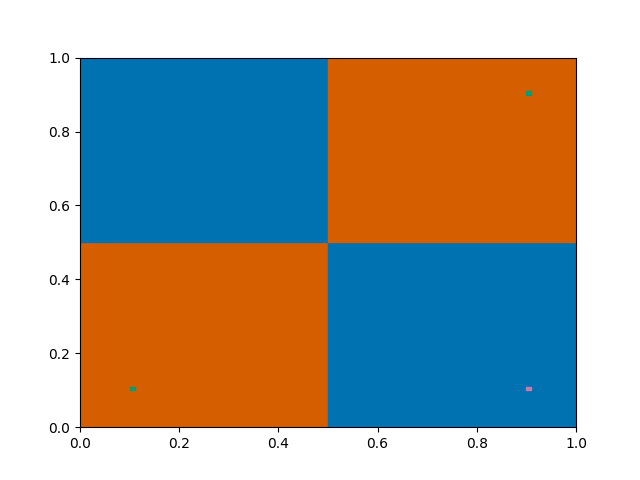

In [11]:
a, f = visualize_categories()

Text(0.1, 0.9, 'x')

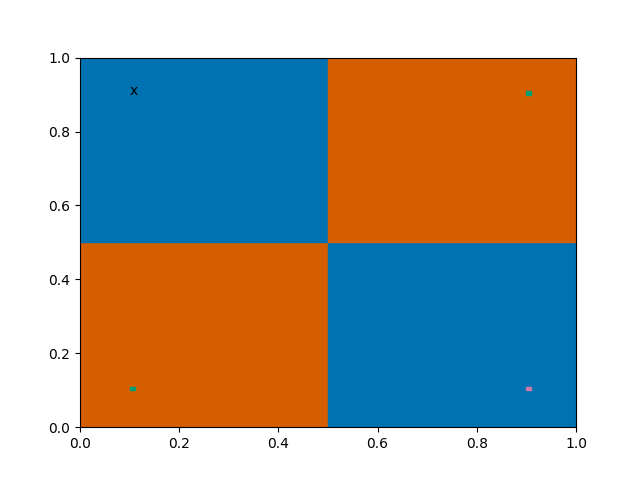

In [12]:
# fourth point - category B
fourth_point = np.array((0.1, 0.9))
a, f = visualize_categories()
a.text(*fourth_point, "x")

In [13]:
complement_encoded_fourth_point = np.concatenate((fourth_point, 1-fourth_point))

J = resonant_a_search(complement_encoded_fourth_point, baseline_vigilance)

# next, check the map field activation (eq. 34)
# instead of a full Fuzzy ART B implementation to get the y_b values, the category vector is used instead
x_ab = np.minimum(category_b_vector, weight_ab[J:])

# squint at eq 35 - the version given |x_ab| < rho_ab|y_b|, is the _mismatch reset_ equation (compare with eq 9)
# rebalancing the inequality, you get |x_ab|/|y_b| >= rho_ab (compare with eq. 7)
match_tracking = np.sum(x_ab)/np.sum(category_b_vector)
map_field_resonance = match_tracking >= map_field_vigilance

# since this is the fist category across the board, map_field_resonance is True
# and we can commit node 0 (weight_a[0]) to category A and learn the new weights for
# the connection between F1 and F2 (weight_a) and between F2 and the "map field" (weight_ab)
# (see eq 11)
weight_a[J, None] = (learning_rate * np.minimum(complement_encoded_fourth_point, weight_a[J, None])) + ((1-learning_rate) * weight_a[J, None])
# see Carpenter et al. 1995 eq 1; the map field learning rules in Carpenter et al. 1992, are brief and fairly opaque
weight_ab[J, None] = ((1 - map_field_learning_rate) * weight_ab[J, None]) + (map_field_learning_rate * np.minimum(category_b_vector, weight_ab[J:]))

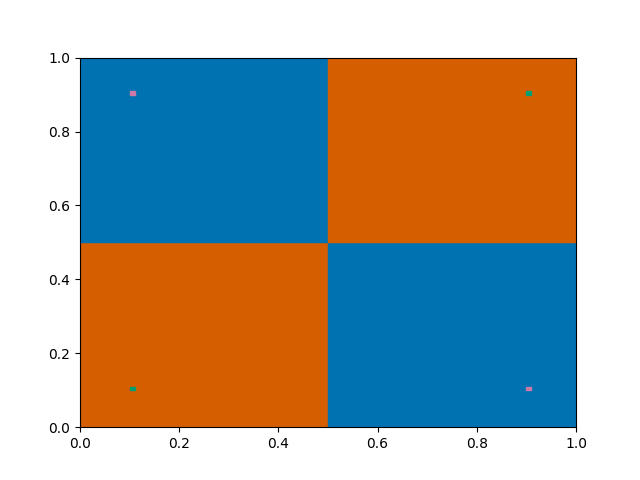

In [14]:
a, f = visualize_categories()

Text(0.11, 0.1, 'x')

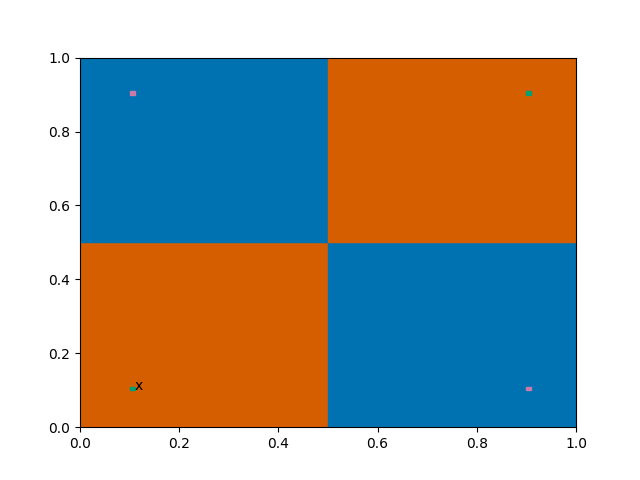

In [15]:
# fifth point - category A
fifth_point = np.array((0.11, 0.1))
a, f = visualize_categories()
a.text(*fifth_point, "x")

In [16]:
complement_encoded_fifth_point = np.concatenate((fifth_point, 1-fifth_point))

J = resonant_a_search(complement_encoded_fifth_point, baseline_vigilance)

# next, check the map field activation (eq. 34)
# instead of a full Fuzzy ART B implementation to get the y_b values, the category vector is used instead
x_ab = np.minimum(category_a_vector, weight_ab[J:])

# squint at eq 35 - the version given |x_ab| < rho_ab|y_b|, is the _mismatch reset_ equation (compare with eq 9)
# rebalancing the inequality, you get |x_ab|/|y_b| >= rho_ab (compare with eq. 7)
match_tracking = np.sum(x_ab)/np.sum(category_a_vector)
map_field_resonance = match_tracking >= map_field_vigilance

# since this is the fist category across the board, map_field_resonance is True
# and we can commit node 0 (weight_a[0]) to category A and learn the new weights for
# the connection between F1 and F2 (weight_a) and between F2 and the "map field" (weight_ab)
# (see eq 11)
weight_a[J, None] = (learning_rate * np.minimum(complement_encoded_fifth_point, weight_a[J, None])) + ((1-learning_rate) * weight_a[J, None])
# see Carpenter et al. 1995 eq 1; the map field learning rules in Carpenter et al. 1992, are brief and fairly opaque
weight_ab[J, None] = ((1 - map_field_learning_rate) * weight_ab[J, None]) + (map_field_learning_rate * np.minimum(category_a_vector, weight_ab[J:]))

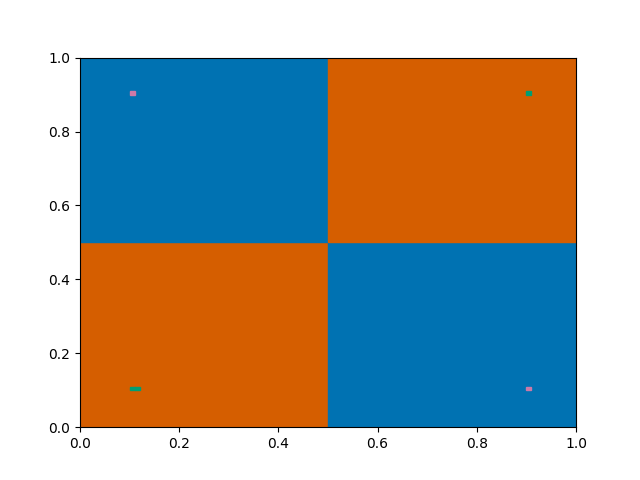

In [17]:
a, f = visualize_categories()

Text(0.13, 0.1, 'x')

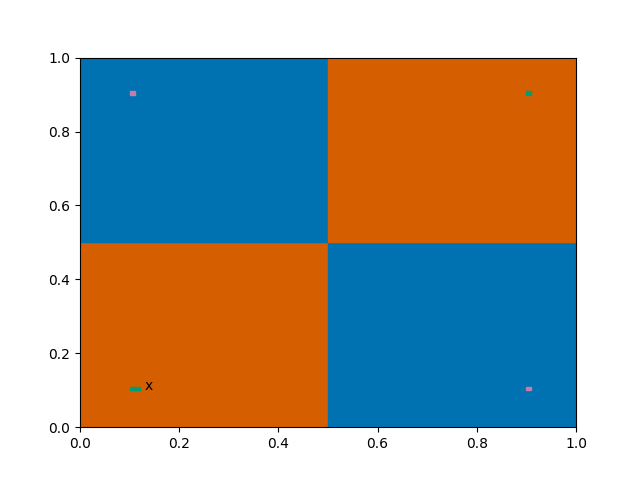

In [18]:
# sixth point - category A
sixth_point = np.array((0.13, 0.1))
a, f = visualize_categories()
a.text(*sixth_point, "x")

In [19]:
complement_encoded_sixth_point = np.concatenate((sixth_point, 1-sixth_point))

J = resonant_a_search(complement_encoded_sixth_point, baseline_vigilance)

# next, check the map field activation (eq. 34)
# instead of a full Fuzzy ART B implementation to get the y_b values, the category vector is used instead
x_ab = np.minimum(category_a_vector, weight_ab[J:])

# squint at eq 35 - the version given |x_ab| < rho_ab|y_b|, is the _mismatch reset_ equation (compare with eq 9)
# rebalancing the inequality, you get |x_ab|/|y_b| >= rho_ab (compare with eq. 7)
match_tracking = np.sum(x_ab)/np.sum(category_a_vector)
map_field_resonance = match_tracking >= map_field_vigilance

# since this is the fist category across the board, map_field_resonance is True
# and we can commit node 0 (weight_a[0]) to category A and learn the new weights for
# the connection between F1 and F2 (weight_a) and between F2 and the "map field" (weight_ab)
# (see eq 11)
weight_a[J, None] = (learning_rate * np.minimum(complement_encoded_sixth_point, weight_a[J, None])) + ((1-learning_rate) * weight_a[J, None])
# see Carpenter et al. 1995 eq 1; the map field learning rules in Carpenter et al. 1992, are brief and fairly opaque
weight_ab[J, None] = ((1 - map_field_learning_rate) * weight_ab[J, None]) + (map_field_learning_rate * np.minimum(category_a_vector, weight_ab[J:]))

Text(0.14, 0.1, 'x')

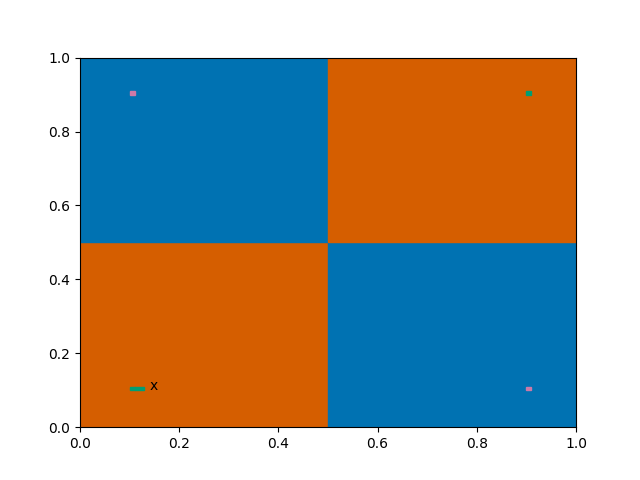

In [20]:
seventh_point = np.array((0.14, 0.1))
a, f = visualize_categories()
a.text(*seventh_point, "x")

In [24]:
complement_encoded_seventh_point = np.concatenate((seventh_point, 1-seventh_point))
# what happens if category b appears in an area where category_a is predicted?
# the match field resonance is False, leading to a map field reset
# this leads to an increase in vigilance (see around eq 35)
vigilance = baseline_vigilance
epsilon = 0.001
already_reset_nodes = []
map_field_resonance = False
while not map_field_resonance:
    J = resonant_a_search(complement_encoded_seventh_point, vigilance, already_reset_nodes)
    x_ab = np.minimum(category_b_vector, weight_ab[J:])

    match_tracking = np.sum(x_ab)/np.sum(category_b_vector)
    map_field_resonance = match_tracking >= map_field_vigilance
    if map_field_resonance:
            break
    already_reset_nodes.append(J)

    vigilance += epsilon

weight_a[J, None] = (learning_rate * np.minimum(complement_encoded_seventh_point, weight_a[J, None])) + ((1-learning_rate) * weight_a[J, None])
weight_ab[J, None] = ((1 - map_field_learning_rate) * weight_ab[J, None]) + (map_field_learning_rate * np.minimum(category_b_vector, weight_ab[J:]))

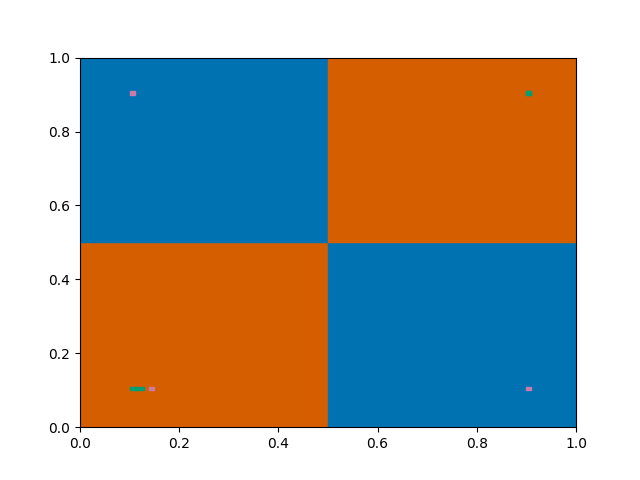

In [25]:
a, f = visualize_categories()